# ASHRAE Kaggle Challenge

<a href='#1'>1. Introduction</a>

<a href='#2'>3. Combining Datasets</a>

<a href='#3'>4. Memory Limitation</a>

<a href='#4'>5. Missing Values</a>

<a href='#5'>6.EDA</a>

<a href='#6'>7. Model Training</a>

<a href='#7'>8. Model Predictions and Kaggle Submission</a>

# <a id='2'>1. Introduction</a>

**Quelle sera la consommation d'un bâtiment ?** C'est la question que pose ce challenge et donc celle à laquelle nous tenterons de répondre le plus précisément possible (la mesure de précision utilisée est la *RMSLE*, *Root Mean Square Logarithmic Error*).

Selon le ministère de la transition écologique, qui est en charge de l'établissement du calcul de diagnostique de performance écologique (*DPE*) des bâtiments et logements en France, les consommations réelles des bâtiments dépendent très directement des conditions d’usage et de la température effective de chauffage ; les consommations estimées ne sont pas une garantie contractuelle, mais elles permettent une comparaison objective de la qualité des logements et bâtiments mis en vente ou loués.

Fort heureusement nous disposons de plusieurs datasets nous renseignant sur les bâtiments étudiés :

In [1]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn
import statistics
# from fastai.tabular.core import df_shrink

In [2]:
#load data
train = pd.read_csv('kaggle/input/ashrae-energy-prediction/train.csv', memory_map=True)
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('kaggle/input/ashrae-energy-prediction/test.csv', memory_map=True)
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_train.csv', memory_map=True)
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_test.csv', memory_map=True)
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp']) 
build_meta = pd.read_csv('kaggle/input/ashrae-energy-prediction/building_metadata.csv', memory_map=True)

In [3]:
len(train), len(test)

(20216100, 41697600)

Exécuter les lignes de la cellule suivante pour obtenir un échantillon :

In [4]:
# train = train.sample(frac = 0.0005)
# test = test.sample(frac = 0.0005)

In [5]:
train.shape

(20216100, 4)

In [6]:
test.shape

(41697600, 4)

# <a id='2'>2. Combining Datasets</a>
Nous allons rassembler tous les datasets en seulement 2 jeux de données train et test.

In [7]:
weather_test.timestamp = pd.to_datetime(weather_test.timestamp) #pour la compatibilité avec les autres jeux de données
weather_train.timestamp = pd.to_datetime(weather_train.timestamp) 

In [8]:
#merge
train_m = train.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
test_m = test_m.merge(weather_test, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
del build_meta, weather_train, weather_test
import gc
gc.collect() #pour limiter l'espace utilisé
train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [9]:
del train, test

# <a id='3'>3. Memory Limitation</a>

In [26]:
# from fastai.tabular.core import df_shrink
# start_mem = train_m.memory_usage().sum() / 1024**2
# train_m = df_shrink(train_m,skip=['meter_reading'])
# end_mem = train_m.memory_usage().sum() / 1024**2
# print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

# start_mem = train_m.memory_usage().sum() / 1024**2
# test_m = test_m.astype(train_m.drop(['meter_reading'],axis=1).dtypes)
# end_mem = train_m.memory_usage().sum() / 1024**2
# print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [27]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m)
test_m = reduce_mem_usage(test_m)

Mem. usage decreased to 1041.10 Mb (60.3% reduction)
Mem. usage decreased to 2147.36 Mb (60.3% reduction)


# <a id='5'>5. EDA</a>

In [28]:
# mat_coorr=train_m.corr()
# sn.heatmap(mat_coorr)
# plt.show()

Pas de corrélation particulière entre `meter_reading` et les autres variables. Il y a cependant quelques corrélations entre certaines variables comme `floor_count` et `square_feet` ou `air_temperature` et `dew_temperature`. nous les traiterons plus tard pour voir si ces corrélations ont une influence sur nos modèles. 

In [29]:
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook

In [30]:
# is_na=train_m.isnull().sum()*100/train_m.shape[0]
# is_na=is_na.sort_values()
# ind = np.arange(len(is_na))

In [31]:
# from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect
# from bokeh.transform import linear_cmap
# from bokeh.palettes import RdYlGn11 as palette
# from bokeh.models import LinearAxis
# from bokeh.models import HoverTool, Legend, LegendItem, Range1d, ColumnDataSource,  RangeTool,  Select, MultiSelect

# p = figure(width = 600, height = 300)
# source = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))

In [32]:
# color_mapper = linear_cmap(palette=palette, low=0, high=100, field_name='y')

# hist1 = p.vbar(x='x', top = 'y' , width=1,  source=source, line_color=color_mapper, fill_color = color_mapper, name = "Histogramme",alpha=0.6)

# h = HoverTool( # code pour l'outil qui affiche les informations de la courbe en passant la souris dessus
#     tooltips=[
#         ('Variable', '@xname'),
#         ('Pourcentage de NA', '$y'),#pour obtenir le nom de la courbe sur laquelle se trouve le pointeur
#     ],
#     renderers = [hist1]#, j]
# )
# p.add_tools(h)


# #show(p)

In [33]:
# plt.bar(ind, is_na.values)
# plt.xticks(ind,is_na.index,rotation=90)
# plt.ylabel("Pourcentage de NA")
# plt.show()

Les labels `floor_count` et `year_built` sont ceux pour lesquels il y a le plus de NA. C'est dommage car ce sont des indexs qui intuitivement auront beaucoup d'influence sur l'energie consommée.

In [34]:
# train_m['hour_datetime'] = train_m['timestamp'].dt.hour.astype(np.int8)  
# train_m['day_week'] = train_m['timestamp'].dt.dayofweek.astype(np.int8)

In [35]:
# p2 = figure(width = 600, height = 300)
# p3 = figure(width = 600, height = 300)#,x_axis_type = 'datetime')
# # source2 = ColumnDataSource(data=dict(x=ind, y=is_na.values, xname = is_na.index.to_list()))
# # p.line(df['Date'], df.vol.mul(df.vol), line_width = 3, name= 'données réelles', color = 'purple')
# # p2.line(train_m.hour_datetime, train_m.meter_reading, line_width = 2, color='black', name = 'Par heure')
# p2.line(train_m.groupby('hour_datetime').hour_datetime.mean(), train_m[['hour_datetime', 'meter_reading']].groupby('hour_datetime').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par heure')

# legend_list = []
# for i in range(len(p2.renderers)):
#         leg_tmp = LegendItem(label=p2.renderers[i].name, renderers = [p2.renderers[i]])
#         legend_list.append(leg_tmp)
# legend = Legend(items=legend_list, location='top_right')
# p2.add_layout(legend)

# # show(p2)

# p3.line(train_m.groupby('day_week').day_week.mean(), train_m[['day_week', 'meter_reading']].groupby('day_week').meter_reading.mean(), line_width = 2, color='red', name = 'Meter reading par jour')


# legend_list = []
# for i in range(len(p3.renderers)):
#         leg_tmp = LegendItem(label=p3.renderers[i].name, renderers = [p3.renderers[i]])
#         legend_list.append(leg_tmp)
# legend = Legend(items=legend_list, location='top_right')
# p3.add_layout(legend)




# show(p3)

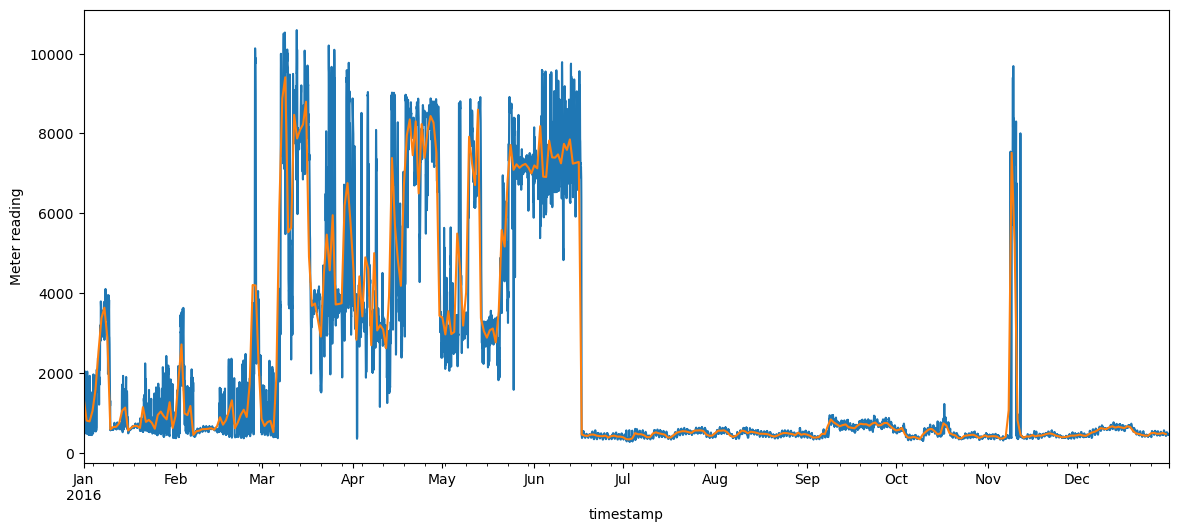

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
# axes.set_title('Metre relevé moyen par jour et par heure');
# axes.legend();
# plt.show()

La forme de la distribution de la valeur cible dans le temps est plutôt étrange. On observe des pics irréguliers. Regardons de plus près.

In [37]:
# import warnings
# warnings.filterwarnings("ignore")

In [38]:
# fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_pu=list(train_m['primary_use'].value_counts().index);
# for i in range(len(list_pu)):
#     train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
#     train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
#     axes[i%8][i//8].legend();
#     axes[i%8][i//8].set_title(list_pu[i]);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()

Notre problème se situe dans Education.

In [39]:
# fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_sid=list(train_m['site_id'].value_counts().index);
# train_hist=train_m[train_m['primary_use'] == 'Education']
# for i in range(len(list_sid)):
#     try :
#         train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
#         train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
#         axes[i%8][i//8].legend();
#     except :
#         pass
#     axes[i%8][i//8].set_title(i);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()
# del train_hist;

Notre problème se situe dans le 13.

In [40]:
# fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
# train_hist=train_m[train_m['primary_use'] == 'Education']
# train_hist2=train_hist[train_hist['site_id'] == 13]
# list_met=list(train_hist2['meter'].value_counts().index);
# for i in range(len(list_met)):
#     try :
#         train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], label='Par heure').set_ylabel('Metre relevé moyen');
#         train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i],  label='Par jour').set_xlabel('');
#         axes[i].legend();
#     except TypeError:
#         pass
#     axes[i].set_title(list_met[i]);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()
# del train_hist;
# del train_hist2;

Le problème se situe dans le metre de type 2.

In [41]:
# fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
# train_hist=train_m[train_m['primary_use'] == 'Education']
# train_hist2=train_hist[train_hist['site_id'] == 13]
# train_hist3=train_hist2[train_hist2['meter']==2]
# list_build=list(train_hist3['building_id'].value_counts().index);
# for i in range(len(list_build)):
#     try :
#         train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], label='Par heure').set_ylabel('Metre relevé moyen');
#         train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9],  label='Par jour').set_xlabel('');
#         axes[i%9][i//9].legend();
#     except TypeError:
#         pass
#     axes[i%9][i//9].set_title(list_build[i]);
#     plt.subplots_adjust(hspace=0.45)
# plt.show()
# del train_hist;
# del train_hist2;
# del train_hist3;

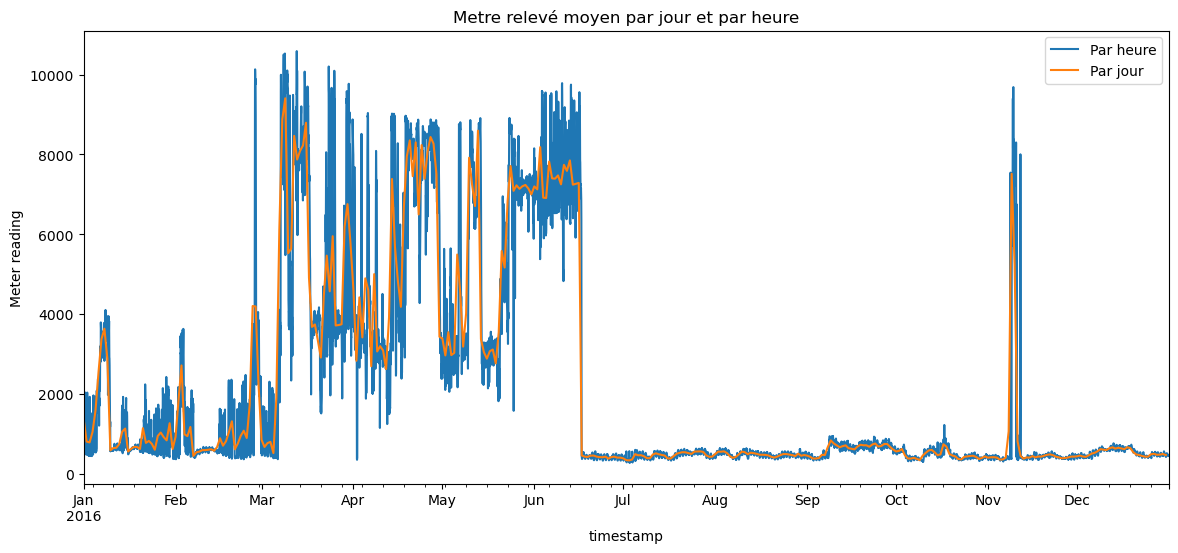

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

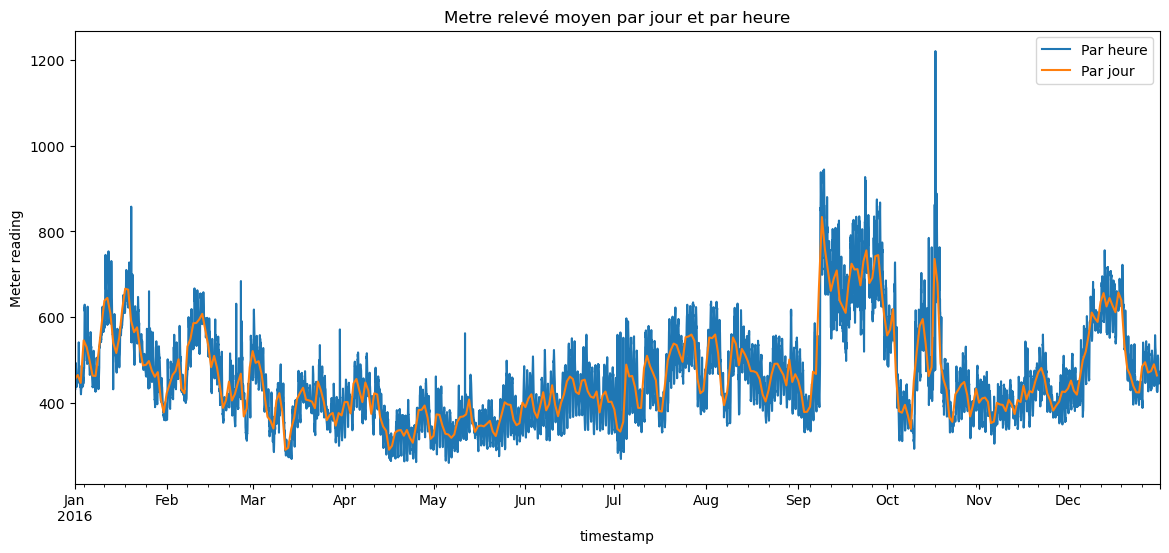

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
new_train=train_m[train_m['building_id'] != 1099]
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

In [44]:
new_test=test_m
new_test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [45]:
del train_m
del test_m
gc.collect()

12009

Remplacement NA

In [46]:
# for i in list_pu:
#     print(i)
#     print(new_train[new_train['primary_use']==i].isnull().sum()*100/new_train[new_train['primary_use']==i].shape[0])
#     print("")

`Services`, `Food sales and service`, `Religious worship` n'ont aucune donnée pour la variable `floor_count`. Nous allons d'abord combler ce qu'il manque dans les autres catégories par la moyenne. 

In [47]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.955237
floor_count           82.637685
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [48]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count           82.605042
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

In [49]:
import statistics
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)        


In [50]:
for i in range(len(list_pu)):
    if (list_pu[i]!="Services") & (list_pu[i]!="Food sales and service") & (list_pu[i]!="Religious worship") :
        new_train.loc[new_train.primary_use==list_pu[i],['floor_count']]=new_train[new_train['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['floor_count']]=new_test[new_test['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [51]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [52]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['floor_count']]=new_train[new_train['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['floor_count']]=new_test[new_test['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [53]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.955237
floor_count            0.000000
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [54]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count            0.000000
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

C'est bon pour `floor_count`, au tour de `year_built`

In [55]:
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)

In [56]:
for i in range(len(list_pu)):
    if list_pu[i]!="Services":
        new_train.loc[new_train.primary_use==list_pu[i],['year_built']]=new_train[new_train['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['year_built']]=new_test[new_test['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean_test[i])
new_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,5.246094,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,5.246094,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,5.246094,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,5.246094,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,5.246094,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [57]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.477852
floor_count            0.000000
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [58]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.462185
floor_count            0.000000
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

In [59]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [60]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['year_built']]=new_train[new_train['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['year_built']]=new_test[new_test['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [61]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [62]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

Pour les infos météo, on se base seulement selon le site. Se baser sur `primary_use` n'aurait pas de sens pour ce type de donnée.

In [63]:
for i in list_sid:
    print(i)
    print(new_train[new_train['site_id']==i].isnull().sum()*100/new_train[new_train['site_id']==i].shape[0])
    print("")

13
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.022790
cloud_coverage        48.947571
dew_temperature        0.022790
precip_depth_1_hr      0.147688
sea_level_pressure     1.377999
wind_direction         2.481296
wind_speed             0.022790
dtype: float64

9
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.102563
cloud_coverage        39.411560
dew_temperature        0.125330
precip_depth_1_hr      0.125218
sea_level_pressure     2.770252
wind_direction     

In [64]:
#cloud coverage
#site id 7, 11 n'ont aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if (list_sid[i] != 7) & (list_sid[i] != 11):
        new_train.loc[new_train.site_id==list_sid[i],['cloud_coverage']]=new_train[new_train['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['cloud_coverage']]=new_test[new_test['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875


In [65]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 2% de cloud_coverage inconnu

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.478520
cloud_coverage         2.406808
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [66]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.532167
cloud_coverage         2.352941
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

In [67]:
#precip_depth_1_hr
#12, 5, 1 n'ont pas de donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)
        
for i in range(len(list_sid)):
    if (list_sid[i] != 12) & (list_sid[i] != 5) & (list_sid[i] != 1):
        new_train.loc[new_train.site_id==list_sid[i],['precip_depth_1_hr']]=new_train[new_train['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['precip_depth_1_hr']]=new_test[new_test['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean_test[i])
new_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0


In [68]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 8% d'inconnu pour precip_depth_1_hr

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.478520
cloud_coverage        2.406808
dew_temperature       0.495759
precip_depth_1_hr     8.174068
sea_level_pressure    6.096616
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [69]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.532167
cloud_coverage        2.352941
dew_temperature       0.625453
precip_depth_1_hr     7.899160
sea_level_pressure    6.035901
wind_direction        7.143488
wind_speed            0.724476
dtype: float64

In [70]:
#sea_lever_pressure
#le site 5 n'a aucune donnée

list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    if list_sid[i] != 5:
        new_train.loc[new_train.site_id==list_sid[i],['sea_level_pressure']]=new_train[new_train['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean[i])
        new_test.loc[new_test.site_id==list_sid[i],['sea_level_pressure']]=new_test[new_test['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean_test[i])
new_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,5.246094,25.0,6.0,20.0,1.389648,1019.5,0.0,0.0


In [71]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 3.8% d'inconnu pour sea_level_pressure

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.478520
cloud_coverage        2.406808
dew_temperature       0.495759
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [72]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.532167
cloud_coverage        2.352941
dew_temperature       0.625453
precip_depth_1_hr     7.899160
sea_level_pressure    3.739496
wind_direction        7.143488
wind_speed            0.724476
dtype: float64

In [73]:
#air_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['air_temperature']]=new_train[new_train['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['air_temperature']]=new_test[new_test['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean_test[i])
new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.495759
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [74]:
#dew_temperature
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['dew_temperature']]=new_train[new_train['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['dew_temperature']]=new_test[new_test['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.000000
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [75]:
#wind_direction
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_direction']]=new_train[new_train['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_direction']]=new_test[new_test['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.000000
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        0.000000
wind_speed            0.711299
dtype: float64

In [76]:
#wind_speed
list_sid_mean=[]
list_sid_mean_test=[]

for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_speed']]=new_train[new_train['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['wind_speed']]=new_test[new_test['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean_test[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.000000
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        0.000000
wind_speed            0.000000
dtype: float64

In [77]:
new_test.isnull().sum()*100/new_test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.352941
dew_temperature       0.000000
precip_depth_1_hr     7.899160
sea_level_pressure    3.739496
wind_direction        0.000000
wind_speed            0.000000
dtype: float64

Pour bien terminer le travail, et finir de remplir les derniers NA, il faudrait comparer les données météo pour retrouver les villes des différents sites et récupérer les données. On pourrait même remplacer les données moyennes ajoutées aux données météo par les valeurs réelles trouvées.

In [78]:
#FE
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

new_train['date'] = new_train.timestamp.dt.date
new_train ['heure'] = new_train.timestamp.dt.hour
new_train ['mois'] = new_train.timestamp.dt.month
new_train ['joursemaine'] = new_train.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_train.timestamp.min(), end=new_train.timestamp.max())
#new_train['EstVac'] = new_train['timestamp'].isin(vac)

new_test['date'] = new_test.timestamp.dt.date
new_test['heure'] = new_test.timestamp.dt.hour
new_test['mois'] = new_test.timestamp.dt.month
new_test['joursemaine'] = new_test.timestamp.dt.dayofweek

#cal = calendar()
#vac = cal.holidays(start=new_test.timestamp.min(), end=new_test.timestamp.max())
#new_test['EstVac'] = new_test['timestamp'].isin(vac)

In [79]:
new_train.primary_use = new_train.primary_use.astype('category')
new_test.primary_use = new_test.primary_use.astype('category')

In [80]:
train_df=new_train.dropna(axis='columns')
test_df=new_test.dropna(axis='columns')

In [82]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_df['primary_use']) #encode en one hot les variables non numériques qualitatives
train_df['primary_use']=le.transform(train_df['primary_use'])
test_df['primary_use']=le.transform(test_df['primary_use'])
train_df['date']=pd.to_numeric(pd.to_datetime(train_df['date']))
test_df['date']=pd.to_numeric(pd.to_datetime(test_df['date']))
train_df = train_df.drop('timestamp', axis = 1)
test_df = test_df.drop('timestamp', axis = 1)

In [83]:
test_df.shape

(41697600, 16)

In [84]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 847.56 Mb (35.3% reduction)
Mem. usage decreased to 1749.70 Mb (35.3% reduction)


In [85]:
del new_train
del new_test

In [86]:
train_df.to_pickle('kaggle/input/ashrae-energy-prediction/train_df.pkl')
del train_df

In [87]:
test_df.to_pickle('kaggle/input/ashrae-energy-prediction/test_df.pkl')
del test_df

gc.collect()

183

# <a id='6'>6. Model Training</a>

### Data Preparation

In [88]:
train_df = pd.read_pickle('kaggle/input/ashrae-energy-prediction/train_df.pkl')

In [89]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,wind_direction,wind_speed,date,heure,mois,joursemaine
0,0,0,0.0,0,0,7432,2008.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
1,1,0,0.0,0,0,2720,2004.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
2,2,0,0.0,0,0,5376,1991.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
3,3,0,0.0,0,0,23685,2002.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4
4,4,0,0.0,0,0,116607,1975.0,5.246094,25.0,20.0,0.0,0.0,1451606400000000000,0,1,4


In [91]:
X = train_df.drop(['meter_reading'],axis=1)
y = train_df['meter_reading']

del train_df
gc.collect()

237

### Models

#### Evaluation

In [92]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

def rmsle(y, y0): #seul objectif de la compétition
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))
rmsle_score = make_scorer(rmsle, greater_is_better=False)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = lambda model : cross_val_score(model, X, y, scoring=rmsle_score, cv=cv, n_jobs=-1,verbose=2)

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_rg = DecisionTreeRegressor()
print('RMSLE: %.3f (%.3f)' % (np.mean(n_scores(tree_rg)), np.std(n_scores(tree_rg))))
# param_grid = {'splitter' : ['best', 'random'],'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson']}
# model = GridSearchCV(my_tree, param_grid, scoring=MSE)

# predicted = model.predict(test_df)

# print('Best Parameters found for MSE : ',model.best_params_)
# print('Train Score : ',model.score(train_m.drop('meter_reading') , y_train))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x268a3f7c400 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\Clement Bernard\Anaconda3\lib\site-packages\joblib\parallel.py", line 808, in dispatch_one_batch
    tasks = self._ready_batches.get(block=False)
  File "C:\Users\Clement Bernard\Anaconda3\lib\queue.py", line 167, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Clement Bernard\Anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\Clement Bernard\Anaconda3\lib\site-packages\joblib\parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\Clement Bernard\Anaconda3\lib\site-packages\joblib\parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self.

#### Bagging

##### Sklearn Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

##### Random Forest with XGBoost

In [ ]:
from xgboost import XGBRFRegressor

#### Boosting

Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

# <a id='7'>7. Model Predictions and Kaggle Submission</a>

In [ ]:
#obtention des prédictions et du fichier à évaluer 
X_test = test_df
y_test_predict_tree=reg.predict(X_test)

In [ ]:
my_submission = pd.DataFrame({'row_id': test_df.index, 'meter_reading': y_test_predict_tree})
my_submission.to_csv('submission_tree_f.csv', index=False)

In [ ]:
my_submission.shape

In [ ]:
test_df.shape